In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import os

os.chdir('..')
os.chdir('results')

In [57]:
def get_path(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):
    attack_type = 'fgsm_disc_attack' if reg else 'fgsm_attack'
    exp = '_' + exp_name if exp_name else ''
    
    path = '/'.join([dataset, model_name, 'attack', attack_type + exp])

    return path



def combined_df(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):

    path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)
    
    files = os.listdir(path)
    files = [f for f in files if f.endswith('.csv')]

    pattern = r"(?<==).*?(?=.csv)"
    id_pattern = fr"(?<={dataset}_).*?(?=_alpha)"

    all_res = pd.DataFrame()

    for file in files:
        curr_res = pd.read_csv(path + '/' + file, index_col=0)

        curr_res['alpha'] = float(re.search(pattern, file)[0])
        curr_res['model_id'] = re.search(id_pattern, file)[0]

        curr_res.columns = [column.strip(' ') for column in curr_res.columns] 

        all_res = pd.concat([all_res, curr_res], axis=0)

    return all_res.reset_index(drop=True)

def aggregated_results(
    dataset='FordA', 
    model_name='ResidualCNN', 
    exp_name='',
    reg=True,  
    metr='F_EFF_CONC',
    metr_max=True,
    k=1,
    vis = False,
    params=['ACC', 'PROB_HID'],
    figsize=(20, 30),
    save_pic=False):

    all_df = combined_df(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

    grouped = all_df.groupby(['eps', 'alpha'])
    result = grouped.apply(lambda x: x.nlargest(k, metr, keep='last') if metr_max else x.nsmallest(k, metr, keep='last'))


    if vis:
        
        fig, ax = plt.subplots(result['alpha'].nunique(), result['eps'].nunique(), figsize=figsize, sharey=True)
        fig.suptitle(f'{dataset}_{model_name}')

        all_alps = result['alpha'].unique()
        all_eps = result['eps'].unique()

        path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

        for i, row in result.iterrows():

            alp = int(row['alpha']) if row['alpha'].is_integer() else row['alpha']
            eps = row['eps']

            file_path = path + '/' + f'aa_res_{dataset}_{int(row["model_id"])}_alpha={alp}.csv'

            curr_df = pd.read_csv(file_path, index_col=0)
            curr_df.columns = [column.strip(' ') for column in curr_df.columns]

            curr_df = curr_df[curr_df['eps']==eps].set_index('step_id')

            eps_id = np.where(all_eps==eps)[0][0]
            alp_id = np.where(all_alps==alp)[0][0]

            ax[alp_id, eps_id].plot(curr_df[params])
            ax[alp_id, eps_id].axvline(int(row["step_id"]), ls='--', alpha=0.2, color='black')

            ax[alp_id, eps_id].set_title(f'eps={eps}, alpha={alp}, {metr}={row[metr]}, step={int(row["step_id"])}')
            ax[alp_id, eps_id].legend(params)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        if save_pic:
            plt.savefig(f'../{dataset}_{model_name}.jpeg', dpi=120)

    return result

ACC     ROC      PR      F1     EFF        L1  \
eps   alpha                                                           
0.005 0.001   627  0.4129  0.4159  0.4482  0.4569  0.5431   29.5763   
      0.010   176  0.4106  0.4118  0.4475  0.4254  0.5746   41.7692   
      0.100   50   0.3492  0.3433  0.4456  0.1889  0.8111   81.2421   
      1.000   356  0.5174  0.5082  0.4883  0.3038  0.6962   73.5597   
      10.000  815  0.6333  0.6215  0.6064  0.3965  0.6035   72.3402   
      100.000 509  0.6356  0.6237  0.6102  0.3995  0.6005   72.0456   
0.030 0.001   665  0.5045  0.5089  0.4886  0.5575  0.4425   18.9201   
      0.010   218  0.3735  0.3738  0.4370  0.3730  0.6270   87.4690   
      0.100   101  0.3758  0.3709  0.4441  0.2523  0.7477   97.0859   
      1.000   406  0.5864  0.5785  0.5360  0.4371  0.5629   60.3464   
      10.000  865  0.7121  0.7029  0.6889  0.5824  0.4176   48.6043   
      100.000 559  0.7189  0.7099  0.6975  0.5945  0.4055   47.8138   
0.100 0.001   716  0.1394  0.1362  0.4682  0.0389  0.9611   65.3259   
      0.010   257  0.1697  0.1656  0.4683  0.0403  0.9597   61.1349   
      0.100   104  0.1902  0.1854  0.4684  0.0413  0.9587   56.1692   
      1.000   410  0.2038  0.1986  0.4685  0.0419  0.9581   51.3415   
      10.000  917  0.0811  0.0786  0.4841  0.0000  1.0000  234.7979   
      100.000 611  0.1477  0.1432  0.4841  0.0000  1.0000  233.2705   

                   ACC_CORRECT  ACC_ORIG_ADV  ROUGHNESS  ROUGHNESS_NORM  \
eps   alpha                                                               
0.005 0.001   627       0.4723        0.5386     0.1333          1.4193   
      0.010   176       0.4697        0.5364     0.1651          1.7574   
      0.100   50        0.3995        0.4750     0.2647          2.8186   
      1.000   356       0.5763        0.6159     0.2859          3.0444   
      10.000  815       0.5945        0.5318     0.2899          3.0865   
      100.000 509       0.5953        0.5311     0.2899          3.0869   
0.030 0.001   665       0.5771        0.6303     0.1184          1.2605   
      0.010   218       0.4272        0.4992     0.2795          2.9758   
      0.100   101       0.4298        0.5015     0.3433          3.6553   
      1.000   406       0.6395        0.6576     0.2855          3.0396   
      10.000  865       0.6863        0.6136     0.2562          2.7275   
      100.000 559       0.6924        0.6174     0.2537          2.7016   
0.100 0.001   716       0.1594        0.2652     0.2544          2.7089   
      0.010   257       0.1941        0.2955     0.2545          2.7094   
      0.100   104       0.2175        0.3159     0.2526          2.6891   
      1.000   410       0.2331        0.3295     0.2473          2.6332   
      10.000  917       0.0884        0.1992     0.6562          6.9864   
      100.000 611       0.1456        0.2326     0.6685          7.1176   

                   PROB_HID  ACC_DISC  F1_DISC  ROC_AUC_DISC    CONC  \
eps   alpha                                                            
0.005 0.001   627    0.3959    0.6981   0.5676        0.6634  0.3366   
      0.010   176    0.4748    0.7375   0.6441        0.5801  0.4199   
      0.100   50     0.0000    0.5000   0.0000        0.2421  0.7579   
      1.000   356    0.0000    0.5000   0.0000        0.0014  0.9986   
      10.000  815    0.0000    0.5000   0.0000        0.0009  0.9991   
      100.000 509    0.0000    0.5000   0.0000        0.0010  0.9990   
0.030 0.001   665    0.1841    0.5936   0.3153        0.7009  0.2991   
      0.010   218    0.6121    0.8061   0.7594        0.6932  0.3068   
      0.100   101    0.0000    0.5000   0.0000        0.0608  0.9392   
      1.000   406    0.0000    0.5000   0.0000        0.0451  0.9549   
      10.000  865    0.0000    0.5000   0.0000        0.0482  0.9518   
      100.000 559    0.0000    0.5000   0.0000        0.0496  0.9504   
0.100 0.001   716    0.9889    0.9943   0.9943        0.9955  0.0045   
      0.010   257   

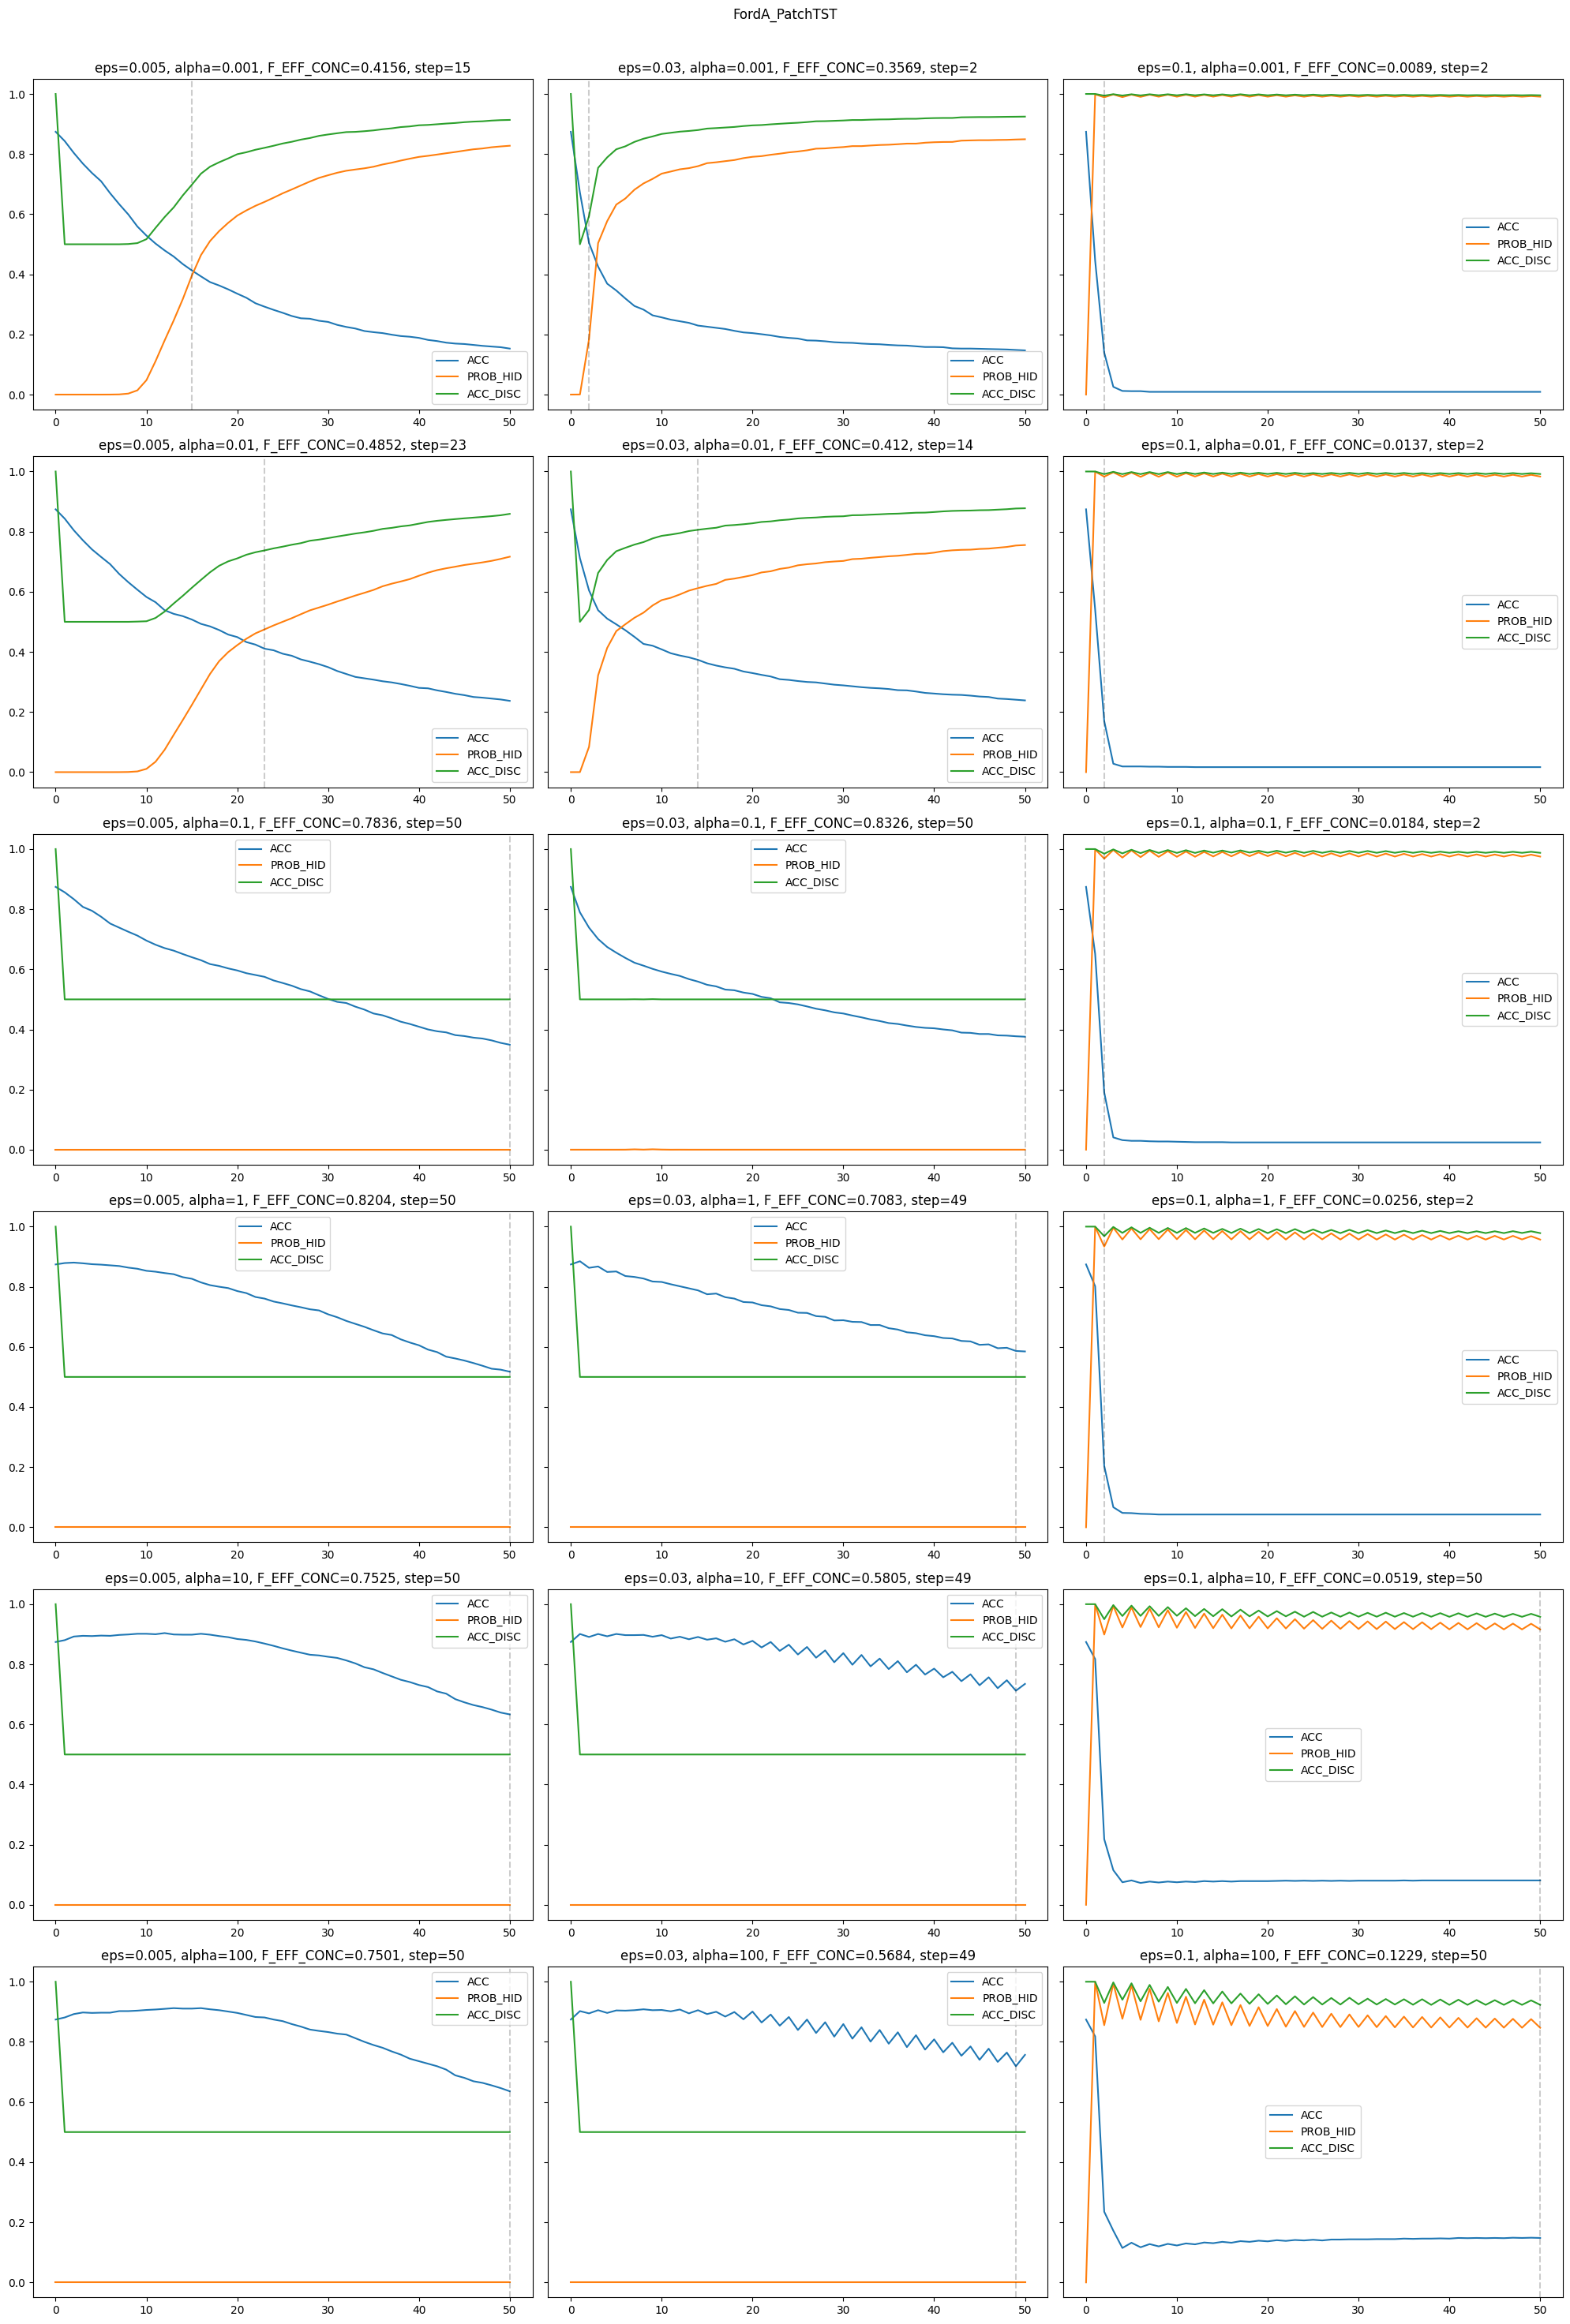

In [58]:
aggregated_results(dataset='FordA', model_name='PatchTST', exp_name="CLEAN", vis=True, params=['ACC', 'PROB_HID', 'ACC_DISC'])

In [3]:
res = pd.DataFrame()

for model in ['LSTM', 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']:
    for ds in ['FordA', 'Strawberry', 'GunPointMaleVersusFemale', 'FreezerRegularTrain']:
        try:
            aa = aggregated_results(dataset=ds, model_name=model, exp_name="CLEAN")
            aa['model'] = model
            aa['dataset'] = ds

            res = pd.concat([res, aa], axis=0)
        except:
            print(ds, model)

GunPointMaleVersusFemale LSTM
FreezerRegularTrain LSTM
FordA TST


In [4]:
res

ACC     ROC      PR      F1     EFF        L1  \
eps   alpha                                                           
0.005 0.001   614  0.7162  0.7163  0.6408  0.7102  0.2898    0.3955   
      0.010   171  0.4614  0.4598  0.4659  0.4230  0.5770    1.7772   
      0.100   50   0.5821  0.5821  0.5321  0.5740  0.4260    1.3756   
      1.000   356  0.7200  0.7202  0.6442  0.7150  0.2850    0.5420   
      10.000  815  0.7629  0.7631  0.6869  0.7590  0.2410    0.3901   
...                   ...     ...     ...     ...     ...       ...   
0.100 0.010   764  0.0046  0.0046  0.4959  0.0084  0.9916  253.1685   
      0.100   305  0.0249  0.0249  0.4777  0.0480  0.9520  383.9549   
      1.000   611  0.0888  0.0888  0.4403  0.1560  0.8440  406.1761   
      10.000  458  0.2088  0.2088  0.4200  0.3098  0.6902  418.2455   
      100.000 125  0.5505  0.5505  0.5280  0.5374  0.4626  407.8937   

                   ACC_CORRECT  ACC_ORIG_ADV  ROUGHNESS  ROUGHNESS_NORM  ...  \
eps   alpha                                                              ...   
0.005 0.001   614       0.9295        0.9457     0.0956          1.0038  ...   
      0.010   171       0.5989        0.6909     0.0996          1.0454  ...   
      0.100   50        0.7555        0.8116     0.0995          1.0448  ...   
      1.000   356       0.9331        0.9475     0.0975          1.0231  ...   
      10.000  815       0.9854        0.9852     0.0971          1.0195  ...   
...                        ...           ...        ...             ...  ...   
0.100 0.010   764       0.0047        0.0281     1.2930         29.3028  ...   
      0.100   305       0.0255        0.0484     2.3133         52.4234  ...   
      1.000   611       0.0909        0.1123     2.5397         57.5552  ...   
      10.000  458       0.2138        0.2323     2.6703         60.5139  ...   
      100.000 125       0.5598        0.5663     2.6069         59.0774  ...   

                   F1_DISC  ROC_AUC_DISC    CONC  F_EFF_CONC  step_id    eps  \
eps   alpha                                                                    
0.005 0.001   614   0.0024        0.6406  0.3594      0.3208      2.0  0.005   
      0.010   171   0.0426        0.7076  0.2924      0.3881     18.0  0.005   
      0.100   50    0.0020        0.6013  0.3987      0.4119     50.0  0.005   
      1.000   356   0.0027        0.5646  0.4354      0.3445     50.0  0.005   
      10.000  815   0.0021        0.5612  0.4388      0.3111     50.0  0.005   
...                    ...           ...     ...         ...      ...    ...   
0.100 0.010   764   0.7707        0.6274  0.3726      0.5417     50.0  0.100   
      0.100   305   0.2530        0.1449  0.8551      0.9010     50.0  0.100   
      1.000   611   0.0638        0.0330  0.9670      0.9013     50.0  0.100   
      10.000  458   0.0035        0.0018  0.9982      0.8161     50.0  0.100   
      100.000 125   0.0021        0.0011  0.9989      0.6324     23.0  0.100   

                     alpha  model_id     model              dataset  
eps   alpha                                                          
0.005 0.001   614    0.001         0      LSTM                FordA  
      0.010   171    0.010         0      LSTM                FordA  
      0.100   50     0.100         0      LSTM                FordA  
      1.000   356    1.000         0      LSTM                FordA  
      10.000  815   10.000         0      LSTM                FordA  
...                    ...       ...       ...                  ...  
0.100 0.010   764    0.010         0  PatchTST  FreezerRegularTrain  
      0.100   305    0.100         0  PatchTST  FreezerRegularTrain  
      1.000   611    1.000         0  PatchTST  FreezerRegularTrain  
      10.000  458   10.000         0  PatchTST  FreezerRegularTrain  
      100.000 125  100.000         0  PatchTST  FreezerRegularTrain  

[378 rows x 22 columns]

In [7]:
res.groupby(['dataset', 'model']).max('F_EFF_CONC').reset_index().pivot(index='model', columns='dataset', values='F_EFF_CONC')

dataset,FordA,FreezerRegularTrain,GunPointMaleVersusFemale,Strawberry
model,,,,
LSTM,0.4119,NaN,NaN,0.8624
PatchTST,0.8326,0.9013,0.6292,0.9757
RNNA,0.3555,0.6260,0.9936,0.6746
ResidualCNN,0.2988,0.9361,0.2780,0.0768
S4,0.7289,0.9694,0.8276,0.8072
TST,NaN,0.8516,0.8054,0.5437


In [28]:
res.groupby(['dataset', 'model'])['F_EFF_CONC'].idxmax().to_frame()['F_EFF_CONC'].apply(lambda x: (x[0], x[1]))

dataset                   model      
FordA                     LSTM            (0.005, 0.1)
                          PatchTST         (0.03, 0.1)
                          RNNA            (0.005, 0.1)
                          ResidualCNN    (0.005, 0.01)
                          S4              (0.1, 100.0)
FreezerRegularTrain       PatchTST          (0.1, 1.0)
                          RNNA            (0.005, 1.0)
                          ResidualCNN    (0.005, 10.0)
                          S4              (0.03, 0.01)
                          TST             (0.005, 0.1)
GunPointMaleVersusFemale  PatchTST         (0.03, 0.1)
                          RNNA              (0.1, 0.1)
                          ResidualCNN    (0.005, 0.01)
                          S4               (0.03, 0.1)
                          TST              (0.03, 0.1)
Strawberry                LSTM             (0.03, 1.0)
                          PatchTST         (0.03, 0.1)
                          R

In [42]:

tmp = res.groupby(['dataset', 'model'])['F_EFF_CONC'].idxmax().to_frame()

tmp['eps'] = df_res['F_EFF_CONC'] .apply(lambda x: x[0])
tmp['alpha'] = df_res['F_EFF_CONC'] .apply(lambda x: x[1])
tmp['F_EFF_CONC'] = res.groupby(['dataset', 'model'])['F_EFF_CONC'].max()

In [53]:
res[res['dataset']=='FordA'].loc[(0.005, 0.10)].set_index('model')

/tmp/ipykernel_245263/1239657802.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  res[res['dataset']=='FordA'].loc[(0.005, 0.10)].set_index('model')


,ACC,ROC,PR,F1,EFF,L1,ACC_CORRECT,ACC_ORIG_ADV,ROUGHNESS,ROUGHNESS_NORM,...,ACC_DISC,F1_DISC,ROC_AUC_DISC,CONC,F_EFF_CONC,step_id,eps,alpha,model_id,dataset
model,,,,,,,,,,,,,,,,,,,,,
LSTM,0.5821,0.5821,0.5321,0.5740,0.4260,1.3756,0.7555,0.8116,0.0995,1.0448,...,0.5004,0.0020,0.6013,0.3987,0.4119,50.0,0.005,0.1,0,FordA
ResidualCNN,0.7470,0.7458,0.6753,0.7306,0.2694,6.1105,0.8082,0.8227,0.0978,1.0413,...,0.5000,0.0000,0.7599,0.2401,0.2539,50.0,0.005,0.1,0,FordA
RNNA,0.6348,0.6338,0.5709,0.6144,0.3856,28.5689,0.7138,0.7455,0.1678,1.7867,...,0.8155,0.7738,0.6703,0.3297,0.3555,21.0,0.005,0.1,0,FordA
S4,0.3068,0.3060,0.4276,0.2812,0.7188,65.2615,0.3506,0.4318,0.1339,1.4255,...,0.5216,0.1011,0.3322,0.6678,0.6924,43.0,0.005,0.1,0,FordA
PatchTST,0.3492,0.3433,0.4456,0.1889,0.8111,81.2421,0.3995,0.4750,0.2647,2.8186,...,0.5000,0.0000,0.2421,0.7579,0.7836,50.0,0.005,0.1,0,FordA


In [41]:
tmp.reset_index().pivot(index='model', columns='dataset')

F_EFF_CONC                                               \
dataset          FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                 
LSTM            0.4119                 NaN                      NaN   
PatchTST        0.8326              0.9013                   0.6292   
RNNA            0.3555              0.6260                   0.9936   
ResidualCNN     0.2988              0.9361                   0.2780   
S4              0.7289              0.9694                   0.8276   
TST                NaN              0.8516                   0.8054   

                          eps                                               \
dataset     Strawberry  FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                        
LSTM            0.8624  0.005                 NaN                      NaN   
PatchTST        0.9757  0.030               0.100                    0.030   
RNNA            0.6746  0.005               0.005                    0.100   
ResidualCNN     0.0768  0.005               0.005                    0.005   
S4              0.8072  0.100               0.030                    0.030   
TST             0.5437    NaN               0.005                    0.030   

                         alpha                                               \
dataset     Strawberry   FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                         
LSTM             0.030    0.10                 NaN                      NaN   
PatchTST         0.030    0.10                1.00                     0.10   
RNNA             0.005    0.10                1.00                     0.10   
ResidualCNN      0.005    0.01               10.00                     0.01   
S4               0.005  100.00                0.01                     0.10   
TST              0.005     NaN                0.10                     0.10   

                        
dataset     Strawberry  
model                   
LSTM               1.0  
PatchTST           0.1  
RNNA               1.0  
ResidualCNN        1.0  
S4                 1.0  
TST                0.1